In [216]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [260]:
df = pd.read_csv("../../data/kosdaq/price.csv", index_col='date', parse_dates=True)
sn = pd.read_csv("../../data/kosdaq/share_number.csv", index_col='date', parse_dates=True)
pm = pd.read_csv("../../data/kosdaq/price_mod.csv", index_col = 'date', parse_dates = True)

# quality
gp_t = pd.read_csv("../../data/kosdaq/gross_profit.csv", index_col='date', parse_dates=True)
ast_t = pd.read_csv("../../data/kosdaq/asset.csv", index_col='date', parse_dates=True)
lb_t = pd.read_csv("../../data/kosdaq/liability.csv", index_col = 'date', parse_dates = True)
cf_t = pd.read_csv("../../data/kosdaq/cashflow.csv", index_col = 'date', parse_dates = True)
sl_t = pd.read_csv("../../data/kosdaq/sales.csv", index_col = 'date', parse_dates = True)

# value
per_t = pd.read_csv("../../data/kosdaq/per.csv", index_col = 'date', parse_dates = True)
pbr_t = pd.read_csv("../../data/kosdaq/pbr.csv", index_col = 'date', parse_dates = True)
psr_t = pd.read_csv("../../data/kosdaq/psr.csv", index_col = 'date', parse_dates = True)
pcr_t = pd.read_csv("../../data/kosdaq/pcr.csv", index_col = 'date', parse_dates = True)

# 거래정지
suspension = pd.read_csv("../../data/kosdaq/suspension.csv", index_col="date", parse_dates=True, low_memory=False)

In [261]:
# 중국기업 제외
chinese = ['A900110', 'A900120', 'A900070', 'A900080', 'A900250', 'A900260', 'A900270', 'A900280', \
           'A900290', 'A900300', 'A900310', 'A900340', 'A900090', 'A060240']
df.drop(chinese, axis=1, inplace=True)
sn.drop(chinese, axis=1, inplace=True)
pm.drop(chinese, axis=1, inplace=True)
gp_t.drop(chinese, axis=1, inplace=True)
ast_t.drop(chinese, axis=1, inplace=True)
lb_t.drop(chinese, axis=1, inplace=True)
cf_t.drop(chinese, axis=1, inplace=True)
sl_t.drop(chinese, axis=1, inplace=True)
per_t.drop(chinese, axis=1, inplace=True)
pbr_t.drop(chinese, axis=1, inplace=True)
psr_t.drop(chinese, axis=1, inplace=True)
pcr_t.drop(chinese, axis=1, inplace=True)
suspension.drop(chinese, axis=1, inplace=True)

In [262]:
# 거래정지 처리
suspension.index = suspension.index + pd.tseries.offsets.MonthEnd(0)
m_suspension_mask = suspension.groupby('date').last().isnull()

In [263]:
m = 15

market_cap = df * sn
market_cap.index = market_cap.index + pd.tseries.offsets.MonthEnd(0)
m_cap = market_cap.groupby('date').last()

pm.index = pm.index + pd.tseries.offsets.MonthEnd(0)
m_pm = pm.groupby('date').last()
m_ret = (m_pm.fillna(-1) / m_pm.shift(1)).clip(0, 10) - 1

gp = pd.DataFrame(index=m_ret.index).join(gp_t).shift(m)
ast = pd.DataFrame(index=m_ret.index).join(ast_t).shift(m)
lb = pd.DataFrame(index=m_ret.index).join(lb_t).shift(m)
cf = pd.DataFrame(index=m_ret.index).join(cf_t).shift(m)
sl = pd.DataFrame(index=m_ret.index).join(sl_t).shift(m)

df.index = df.index + pd.tseries.offsets.MonthEnd(0)
m_df = df.groupby('date').last()

per_t.index = m_df.index
pbr_t.index = m_df.index
psr_t.index = m_df.index
pcr_t.index = m_df.index
per_t.index = m_df.index

per = per_t.shift(m)
pbr = pbr_t.shift(m)
psr = psr_t.shift(m)
pcr = pcr_t.shift(m)

In [264]:
# quality
pivot = 12

# 수익성 팩터
gpoa = gp/ast # gross profit over asset
cfoa = cf/ast # cashflow profit over asset
gmar = gp/sl  # gross margin
turn = sl/ast

# 성장성 팩터(수익성 팩터, 5년 전과 비교해서 변화 정도 / 총자산)
gpoa_d = (gpoa - gpoa.shift(pivot))/ ast.shift(pivot)
cfoa_d = (cfoa - cfoa.shift(pivot))/ ast.shift(pivot)
gmar_d = (gmar - gmar.shift(pivot))/ sl.shift(pivot)
turn_d = sl/ast - sl.shift(12)/ast.shift(12)

# 안정성 팩터
lev = lb/ast # 총부채 / 총자산
gpvol = gpoa.rolling(pivot).std()  # gross profit volatility
cfvol = cfoa.rolling(pivot).std()  # cashflow volatility

gpoa_rank = gpoa.rank(axis=1, ascending=False)
cfoa_rank = cfoa.rank(axis=1, ascending=False)
gmar_rank = gmar.rank(axis=1, ascending=False)
turn_rank = turn.rank(axis=1, ascending=False)
gpoa_d_rank = gpoa_d.rank(axis=1, ascending=False)
cfoa_d_rank = cfoa_d.rank(axis=1, ascending=False)
gmar_d_rank = gmar_d.rank(axis=1, ascending=False)
turn_d_rank = turn_d.rank(axis=1, ascending=False)
lev_rank = lev.rank(axis=1)
gpvol_rank = gpvol.rank(axis=1)
cfvol_rank = cfvol.rank(axis=1)

gpoa_z = (gpoa_rank.T - gpoa_rank.mean(axis=1)) / gpoa_rank.std(axis=1)
cfoa_z = (cfoa_rank.T - cfoa_rank.mean(axis=1)) / cfoa_rank.std(axis=1)
gmar_z = (gmar_rank.T - gmar_rank.mean(axis=1)) / gmar_rank.std(axis=1)
turn_z = (turn_rank.T - turn_rank.mean(axis=1)) / turn_rank.std(axis=1)
gpoa_d_z = (gpoa_d_rank.T - gpoa_d_rank.mean(axis=1)) / gpoa_d_rank.std(axis=1)
cfoa_d_z = (cfoa_d_rank.T - cfoa_d_rank.mean(axis=1)) / cfoa_d_rank.std(axis=1)
gmar_d_z = (gmar_d_rank.T - gmar_d_rank.mean(axis=1)) / gmar_d_rank.std(axis=1)
turn_d_z = (turn_d_rank.T - turn_d_rank.mean(axis=1)) / turn_d_rank.std(axis=1)
lev_z = (lev_rank.T - lev_rank.mean(axis=1)) / lev_rank.std(axis=1)
gpvol_z = (gpvol_rank.T - gpvol_rank.mean(axis=1)) / gpvol_rank.std(axis=1)
cfvol_z = (cfvol_rank.T - cfvol_rank.mean(axis=1)) / cfvol_rank.std(axis=1)

total_qz = gpoa_z.T + cfoa_z.T + gmar_z.T + turn_z.T + gpoa_d_z.T + cfoa_d_z.T + gmar_d_z.T + turn_d_z.T + lev_z.T + gpvol_z.T + cfvol_z.T
total_qz = ((total_qz.T - total_qz.mean(axis=1)) / total_qz.std(axis=1)).T

In [265]:
# value
per_rank = per.rank(axis=1, pct=True)
pbr_rank = pbr.rank(axis=1, pct=True)
psr_rank = psr.rank(axis=1, pct=True)
pcr_rank = pcr.rank(axis=1, pct=True)

per_z = ((per_rank.T - per_rank.mean(axis=1)) / per_rank.std(axis=1))
pbr_z = ((pbr_rank.T - pbr_rank.mean(axis=1)) / pbr_rank.std(axis=1))
psr_z = ((psr_rank.T - psr_rank.mean(axis=1)) / psr_rank.std(axis=1))
pcr_z = ((pcr_rank.T - pcr_rank.mean(axis=1)) / pcr_rank.std(axis=1))

total_vz = per_z.T + pbr_z.T + psr_z.T + pcr_z.T

In [266]:
def MDD(arr):
    low = np.argmin(arr / np.maximum.accumulate(arr))
    high = np.argmax(arr[:low])
    return high, low, (arr[high] - arr[low]) / arr[high]

def hit_ratio(arr, r, recent_num_ratio=True):
    total = round(sum(arr > 0) / len(arr), 4)
    recent = round(sum(arr[-1*r:] > 0) / len(arr[-1*r:]), 4) if recent_num_ratio else sum(arr[-1*r:] > 0)
    return total, recent

In [267]:
vol_month = m_pm.rolling(50).std()
vol_day = ((pm / pm.shift(1)).clip(0, 10) - 1).rolling(50).std().groupby('date').last()
momentum_mask = m_pm.copy()
for i in range(6):
    momentum_mask[momentum_mask < m_pm.shift(i)] = m_pm.shift(i)[momentum_mask < m_pm.shift(i)]
momentum = (m_pm.shift(1) / m_pm.shift(4)) - (m_pm / momentum_mask) - vol_day * 1.5

momentum_mask = m_pm.shift(1).copy()
for i in range(9):
    momentum_mask[momentum_mask > m_pm.shift(i)] = m_pm.shift(i)[momentum_mask > m_pm.shift(i)]
momentum_mask = (m_pm.shift(1) / momentum_mask) < 2

m_cap_rank = m_cap[m_suspension_mask].rank(axis=1, pct=True)

momentum: high - 2007-09-30 00:00:00, low - 2008-10-31 00:00:00, mdd - 0.507
momentum: high - 2011-04-30 00:00:00, low - 2011-09-30 00:00:00, mdd - 0.3428
value (hit): total - 0.6318, recent - 9


/Users/daeyoung/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


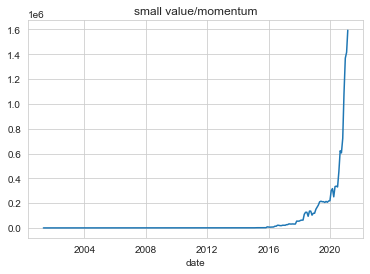

In [268]:
small_mask = m_cap_rank < 0.1
sv_mask = total_vz[small_mask].rank(axis=1, pct=True) < 0.2
sm_mask = momentum[sv_mask & momentum_mask].rank(axis=1, pct=True, ascending=False) < 0.4
sm_cap_weight = (m_cap[sm_mask].T / m_cap[sm_mask].sum(axis=1)).T

sm_r = m_ret[sm_mask.shift(1)].mean(axis=1).fillna(0)
sm_cr = (sm_r + 1).cumprod()[15:]

h, l, mdd = MDD(sm_cr.values)
print(f'momentum: high - {sm_cr.index[h]}, low - {sm_cr.index[l]}, mdd - {round(mdd, 4)}')
t = 90
h, l, mdd = MDD(sm_cr[t:].values)
print(f'momentum: high - {sm_cr[t:].index[h]}, low - {sm_cr[t:].index[l]}, mdd - {round(mdd, 4)}')

t, r = hit_ratio(sm_r.values[15:], 12, False)
print(f'value (hit): total - {t}, recent - {r}')

sns.set_style('whitegrid')
sns.lineplot(sm_cr.index, sm_cr)
plt.title('small value/momentum')
plt.show()

value:    high - 2017-05-31 00:00:00, low - 2017-10-31 00:00:00, mdd - 0.3296
value (~2020.02): high - 2017-05-31 00:00:00, low - 2017-10-31 00:00:00, mdd - 0.3296
value (hit): total - 0.523, recent - 6


/Users/daeyoung/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


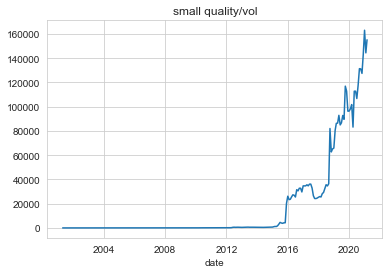

In [269]:
s_mask = m_cap_rank < 0.1
sq_mask = total_qz[s_mask].rank(axis=1, pct=True) < 0.3
# sv_mask = total_vz[sq_mask].rank(axis=1, pct=True) < 0.2
smomen_mask = momentum[sq_mask].rank(axis=1, pct=1, ascending=False) < 0.3
svol_mask = vol_month[smomen_mask & momentum_mask].rank(axis=1, pct=True) < 0.4

# # 동일비중
svol_r = m_ret[svol_mask.shift(1)].mean(axis=1).fillna(0)
svol_cr = (svol_r + 1).cumprod()[15:]

h, l, mdd = MDD(svol_cr.values)
print(f'value:    high - {svol_cr.index[h]}, low - {svol_cr.index[l]}, mdd - {round(mdd, 4)}')
t = 60
h, l, mdd = MDD(svol_cr[t:].values)
print(f'value (~2020.02): high - {svol_cr[t:].index[h]}, low - {svol_cr[t:].index[l]}, mdd - {round(mdd, 4)}')

t, r = hit_ratio(svol_r.values[15:], 12, False)
print(f'value (hit): total - {t}, recent - {r}')

sns.set_style('whitegrid')
sns.lineplot(svol_cr.index, svol_cr)
plt.title('small quality/vol')
plt.show()

In [270]:
print('투자 기업 개수')
print(sm_mask[-30:].sum(axis=1).values)
print(svol_mask[-30:].sum(axis=1).values)
print()

print('평균 수익률')
print(sm_r.mean(), svol_r.mean())
print()

print('수익률 표준편차')
print(sm_r.std(), svol_r.std())
print()

print('수익률 상관관계')
print(sm_r.corr(svol_r))

투자 기업 개수
[2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 1 2 1 2 1 2 2 1 1 2 2 2 2 2 1]
[3 2 2 1 2 2 2 3 2 2 1 1 3 1 2 2 2 2 1 0 1 2 2 3 3 3 2 2 1 3]

평균 수익률
0.07868147529101498 0.0682546716660563

수익률 표준편차
0.29112458289874904 0.2926822488853762

수익률 상관관계
0.7118825210399774


In [1]:
mv_mask = sm_mask|svol_mask
mv_r = m_ret[mv_mask.shift(1)].mean(axis=1).fillna(0)

mv_cr = (mv_r + 1).cumprod()[15:]

h, l, mdd = MDD(mv_cr.values)
print(f'value:    high - {mv_cr.index[h]}, low - {mv_cr.index[l]}, mdd - {round(mdd, 4)}')
t = 60
h, l, mdd = MDD(mv_cr[t:].values)
print(f'value (~2020.02): high - {mv_cr[t:].index[h]}, low - {mv_cr[t:].index[l]}, mdd - {round(mdd, 4)}')

t, r = hit_ratio(mv_r.values[15:], 12, False)
print(f'value (hit): total - {t}, recent - {r}')

sns.set_style('whitegrid')
sns.lineplot(mv_cr.index, mv_cr, label='value')
plt.title('small100')
plt.show()

NameError: name 'sm_mask' is not defined

In [14]:
idx = list(mv_mask.iloc[-1][mv_mask.iloc[-1]==True].index)
code_df = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download', header=0)[0][['회사명', '종목코드']]
for i in range(len(idx)):
    print(code_df.query(f'종목코드=={int(idx[i][1:])}').values[0][0], idx[i][1:], m_pm.iloc[-1][idx[i]])

경남스틸 039240 2035.0
삼일 032280 2240.0
에스티오 098660 2265.0


In [15]:
list(sm_mask.iloc[-1][sm_mask.iloc[-1]==True].index)

['A032280']

In [16]:
# sv100 중 상폐된 기업과 폐지된 월: 없음!
delist_total = (m_ret==-1)
delist_temp = delist_total[delist_total==True]
for i in range(0, len(mv_mask) - 1):
    zero_r = set(delist_temp.iloc[i+1].dropna().index)
    mv_index = set(mv_mask[svol_mask==True].iloc[i].dropna().index)
    if mv_index & zero_r:
        print(mv_mask.index[i], mv_mask & zero_r)

In [42]:
code_df = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download', header=0)[0][['회사명', '종목코드']]
code_df.index = ['A'+'%06d' %i for i in code_df['종목코드']]
del code_df['종목코드']

In [65]:
for i in range(2, 4):
    sm_idx = sm_mask.iloc[-1*i][sm_mask.iloc[-1*i]==True].index
    svol_idx = svol_mask.iloc[-1*i][svol_mask.iloc[-1*i]==True].index
    sm_ret = m_ret.iloc[-1*i+1][sm_idx]
    svol_ret = m_ret.iloc[-1*i+1][svol_idx]
#     print(sm_ret[sm_ret<0.1])
    print(code_df.loc[svol_idx].join(svol_ret).to_string())
    print()
#     print(svol_ret)
#     print(svol_ret[svol_ret<0.1])

          회사명  2021-02-28 00:00:00
A039240  경남스틸             0.035623

          회사명  2021-01-31 00:00:00
A053270  구영테크             0.560606
A039240  경남스틸             0.042440



In [26]:
for i in range(0, len(sm_mask)-1):
    if m_ret[sm_mask.shift(1)] > 0.1:
        sm_mask

Index(['A089530', 'A053050'], dtype='object')


IndexError: index 19 is out of bounds for axis 0 with size 2

In [83]:
sm_mask_momen = svol_mask.copy()
sm_mask_momen[m_cap_rank[m_ret[sm_mask_momen.shift(1)]>0.2]>0.2] = True

momentum: high - 2005-11-30 00:00:00, low - 2005-12-31 00:00:00, mdd - 0.3151
momentum: high - 2018-07-31 00:00:00, low - 2018-10-31 00:00:00, mdd - 0.2983
value (hit): total - 0.5168, recent - 8


/Users/daeyoung/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


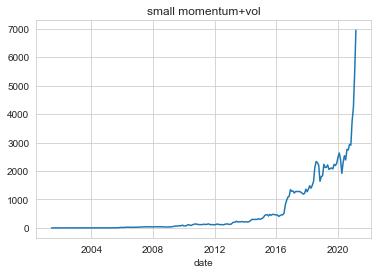

In [84]:
sm_r = m_ret[sm_mask_momen.shift(1)].mean(axis=1).fillna(0)
sm_cr = (sm_r + 1).cumprod()[16:]

h, l, mdd = MDD(sm_cr.values)
print(f'momentum: high - {sm_cr.index[h]}, low - {sm_cr.index[l]}, mdd - {round(mdd, 4)}')
t = 90
h, l, mdd = MDD(sm_cr[t:].values)
print(f'momentum: high - {sm_cr[t:].index[h]}, low - {sm_cr[t:].index[l]}, mdd - {round(mdd, 4)}')

t, r = hit_ratio(sm_r.values[16:], 12, False)
print(f'value (hit): total - {t}, recent - {r}')

sns.set_style('whitegrid')
sns.lineplot(sm_cr.index, sm_cr)
plt.title('small momentum+vol')
plt.show()

In [90]:
(m_df / per_t)['A091990'].dropna()

date
2017-07-31    1279.980158
2017-08-31    1279.980120
2017-09-30    1279.980074
2017-10-31    1279.980111
2017-11-30    1279.980084
2017-12-31    1279.979935
2018-01-31      81.080000
2018-02-28      81.080000
2018-03-31      81.080000
2018-04-30      81.080000
2018-05-31      81.080000
2018-06-30      81.080000
2018-07-31      81.080000
2018-08-31      81.080000
2018-09-30      81.080000
2018-10-31      81.080000
2018-11-30      81.080000
2018-12-31      81.080000
2019-01-31     452.050010
2019-02-28     452.049995
2019-03-31     452.050013
2019-04-30     452.049993
2019-05-31     452.050007
2019-06-30     452.050015
2019-07-31     452.050017
2019-08-31     452.050004
2019-09-30     452.050006
2019-10-31     452.050006
2019-11-30     452.049980
2019-12-31     452.049991
2020-01-31     452.049983
2020-02-29     452.050015
2020-03-31     452.049994
2020-04-30     452.049999
2020-05-31     452.049992
2020-06-30     452.050005
2020-07-31     452.050004
2020-08-31     452.050004
2020-09